# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.815, 即時現金賣出: 30.485


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [3]:
table = []
for x in html.find('table').find('tbody').find_all('tr'):
    temp = []
    temp.append(x.find('div', attrs={'class':'visible-phone print_hide'}).text\
                .replace(" ", "").replace("\n", "").replace("\r", ""))
    temp.append(x.find('td', attrs={'data-table':'本行現金買入'}).text)
    temp.append(x.find('td', attrs={'data-table':'本行現金賣出'}).text)
    
    table.append(temp)

pd.DataFrame(table, columns=['幣別', '現金買入', '現金賣出']).set_index('幣別')

,現金買入,現金賣出
幣別,,
美金(USD),29.815,30.485
港幣(HKD),3.741,3.945
英鎊(GBP),35.66,37.78
澳幣(AUD),17.95,18.73
加拿大幣(CAD),21,21.91
新加坡幣(SGD),20.53,21.44
瑞士法郎(CHF),30.54,31.74
日圓(JPY),0.2682,0.281
南非幣(ZAR),-,-


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

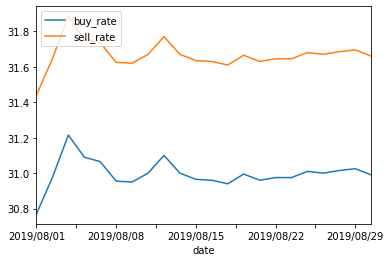

In [71]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

美金(USD)


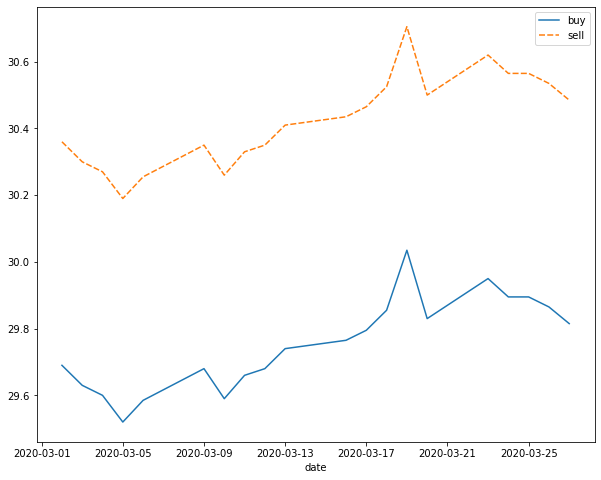

港幣(HKD)


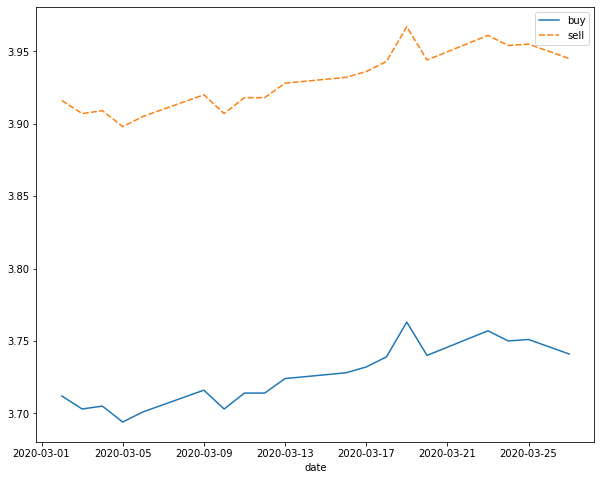

英鎊(GBP)


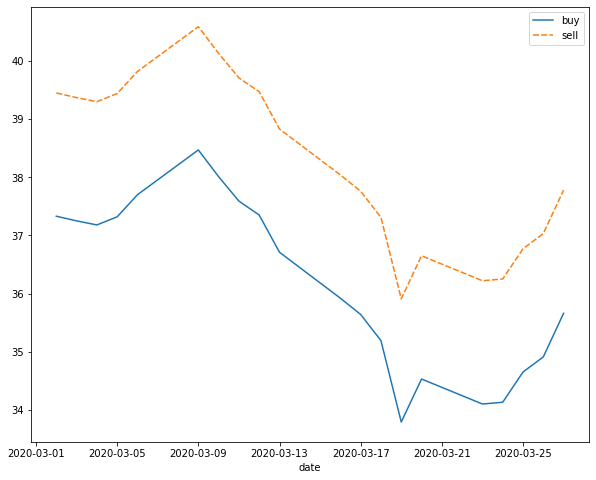

澳幣(AUD)


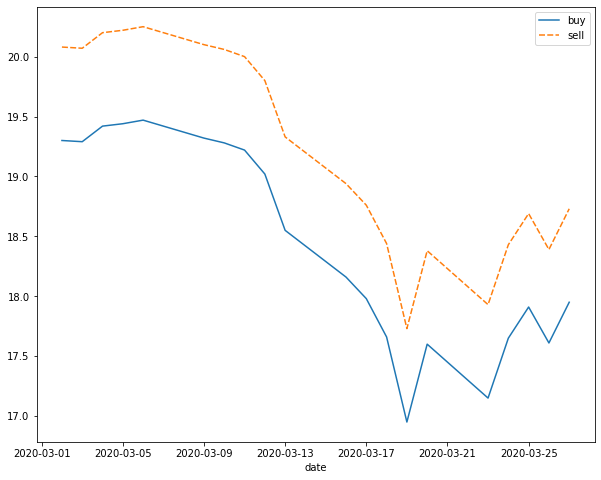

加拿大幣(CAD)


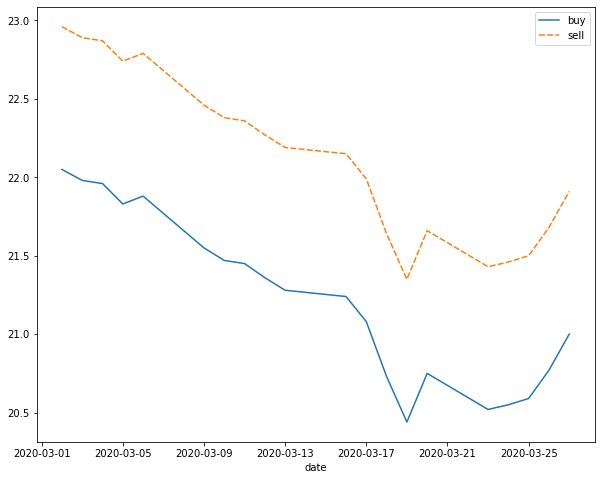

新加坡幣(SGD)


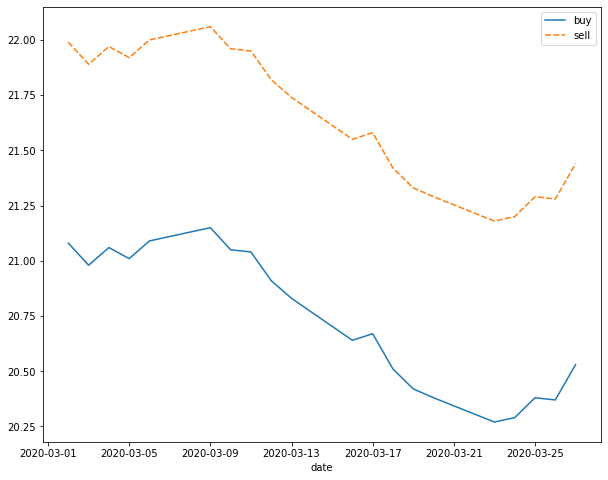

瑞士法郎(CHF)


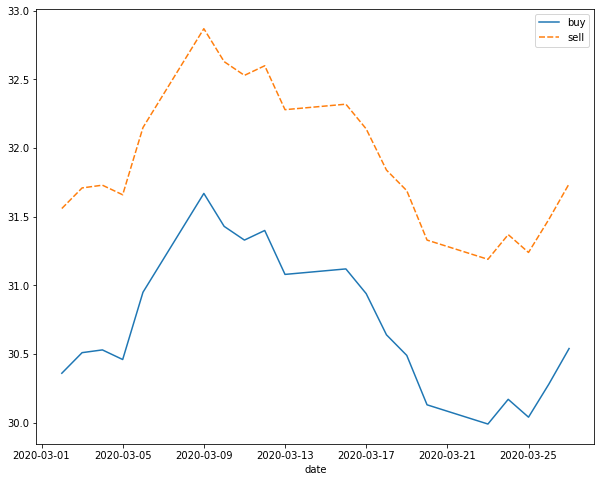

日圓(JPY)


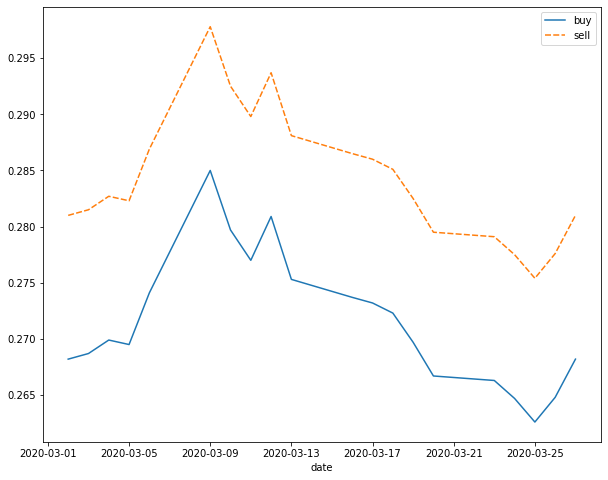

南非幣(ZAR)


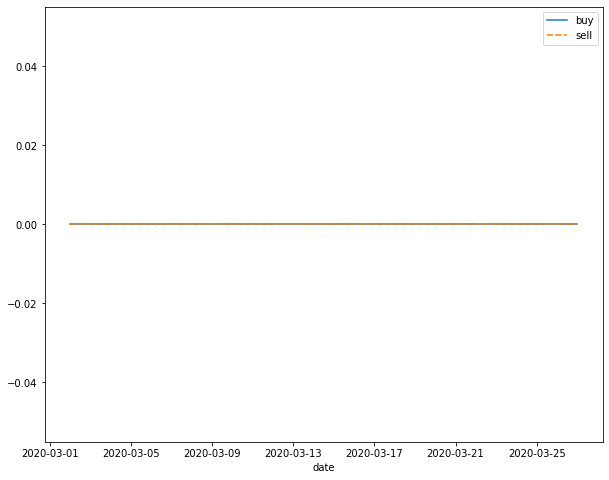

瑞典幣(SEK)


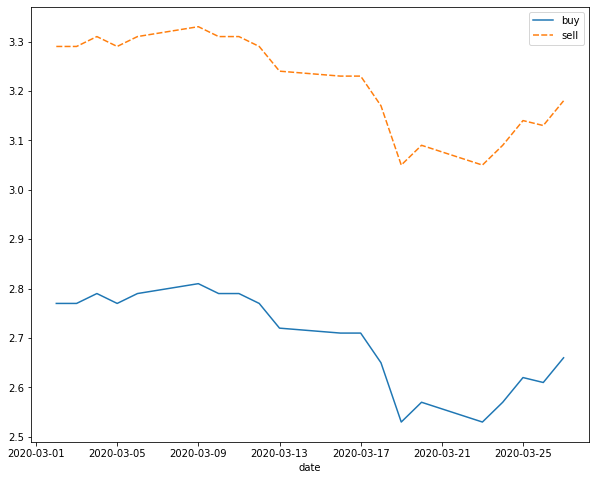

紐元(NZD)


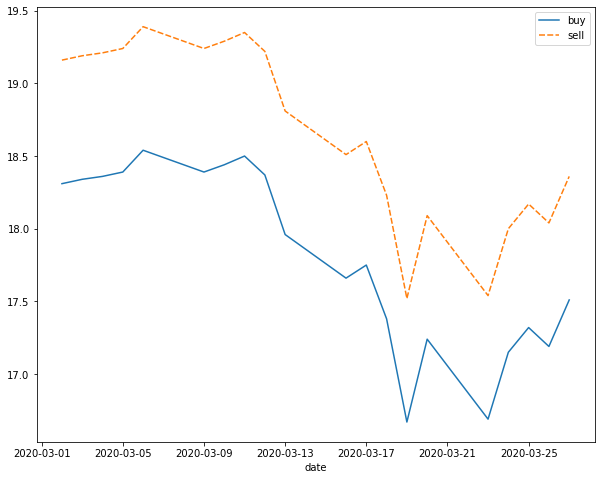

泰幣(THB)


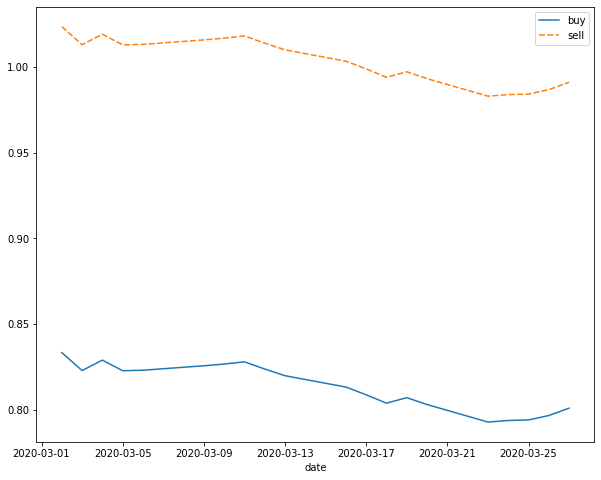

菲國比索(PHP)


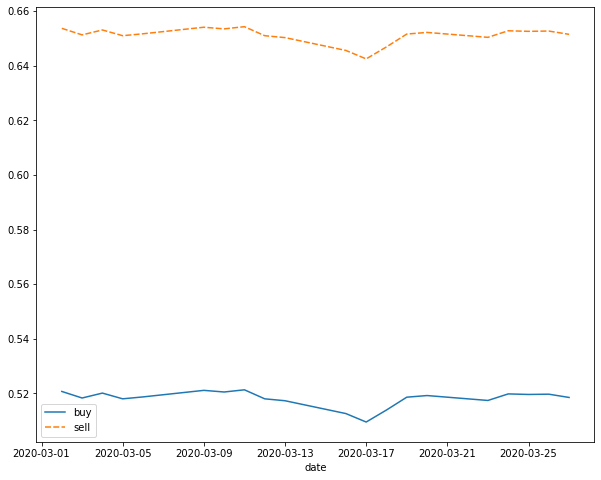

印尼幣(IDR)


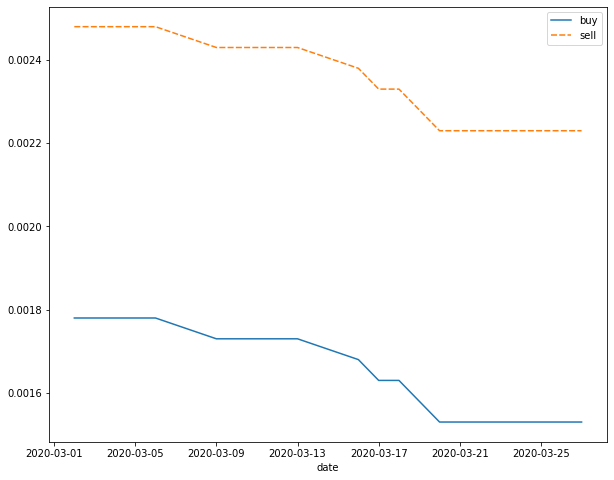

歐元(EUR)


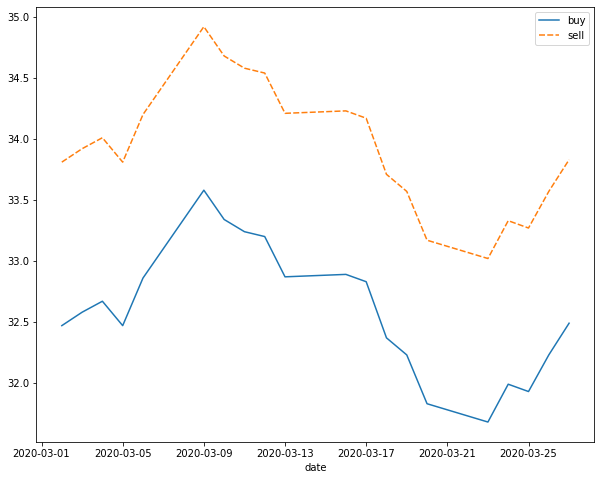

韓元(KRW)


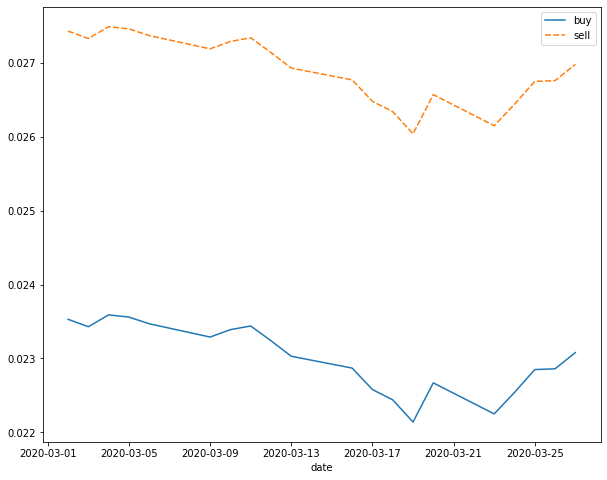

越南盾(VND)


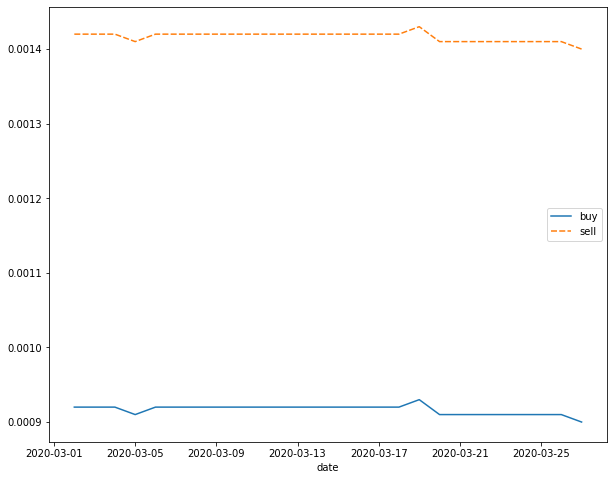

馬來幣(MYR)


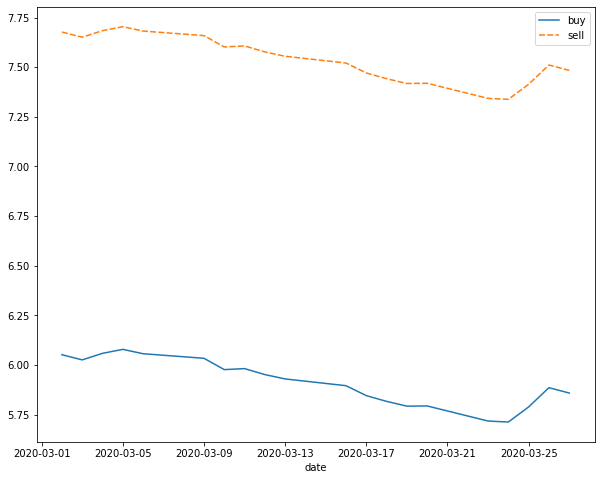

人民幣(CNY)


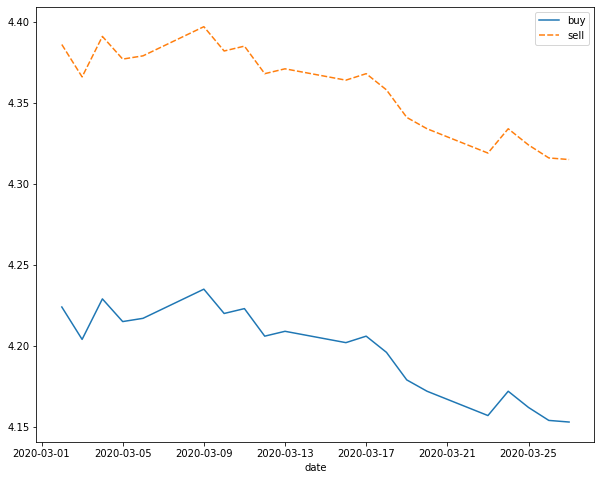

In [70]:
# url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
# resp = requests.get(url)
# soup = BeautifulSoup(resp.text, 'html5lib')
# import seaborn as sns

for x in soup.find('tbody').find_all('tr'):
    print(x.find('div', attrs={'class':'visible-phone print_hide'}).text.replace(' ','').replace('\n', ''))
    
    history_url = x.find('td', attrs={'data-table':'歷史匯率'}).find('a')['href']
    history_url = 'https://rate.bot.com.tw'+history_url.replace('history', 'quote/2020-03')
    history_resp = requests.get(history_url)
    history_soup = BeautifulSoup(history_resp.text, 'html5lib')
    history_table = history_soup.find(class_='table table-striped table-bordered table-condensed table-hover')
    
    
    history = []
    for y in history_table.find('tbody').find_all('tr'):
        temp = []
        temp.append(pd.to_datetime(y.find(class_='text-center').text))
        temp.append(float(y.find_all(class_='rate-content-cash text-right print_table-cell')[0].text))
        temp.append(float(y.find_all(class_='rate-content-cash text-right print_table-cell')[1].text))
        
        history.append(temp)
    
    df = pd.DataFrame(history, columns=['date', 'buy', 'sell']).sort_values(by='date', ascending=True).set_index('date') 
    plt.figure(figsize=(10, 8))
    sns.lineplot(data=df)
    plt.legend(loc='best')
    plt.show()